-------- > epoch 1:  coût moyen entraînement = 2.3666269779205322
-------- > epoch 1:  taux moyen entraînement = 0.10312004387378693
-------- > epoch 1:  coût moyen validation = 2.366946220397949
-------- > epoch 1:  taux moyen validation = 0.10179998725652695
-------- > epoch 2:  coût moyen entraînement = 2.3500778675079346
-------- > epoch 2:  taux moyen entraînement = 0.09904006868600845
-------- > epoch 2:  coût moyen validation = 2.4095897674560547
-------- > epoch 2:  taux moyen validation = 0.10179998725652695
-------- > epoch 3:  coût moyen entraînement = 2.347229242324829
-------- > epoch 3:  taux moyen entraînement = 0.10176005214452744
-------- > epoch 3:  coût moyen validation = 2.314940929412842
-------- > epoch 3:  taux moyen validation = 0.10179998725652695
-------- > epoch 4:  coût moyen entraînement = 2.352490186691284
-------- > epoch 4:  taux moyen entraînement = 0.10216005146503448
-------- > epoch 4:  coût moyen validation = 2.325241804122925
-------- > epoch 4:  t

-------- > epoch 33:  coût moyen entraînement = 2.350501537322998
-------- > epoch 33:  taux moyen entraînement = 0.09990005940198898
-------- > epoch 33:  coût moyen validation = 2.322812557220459
-------- > epoch 33:  taux moyen validation = 0.09770002216100693
-------- > epoch 34:  coût moyen entraînement = 2.3504481315612793
-------- > epoch 34:  taux moyen entraînement = 0.10238005220890045
-------- > epoch 34:  coût moyen validation = 2.3379437923431396
-------- > epoch 34:  taux moyen validation = 0.10070003569126129
-------- > epoch 35:  coût moyen entraînement = 2.349759817123413
-------- > epoch 35:  taux moyen entraînement = 0.10286005586385727
-------- > epoch 35:  coût moyen validation = 2.3276376724243164
-------- > epoch 35:  taux moyen validation = 0.08720000088214874
-------- > epoch 36:  coût moyen entraînement = 2.349200963973999
-------- > epoch 36:  taux moyen entraînement = 0.10050006210803986
-------- > epoch 36:  coût moyen validation = 2.3229687213897705
------

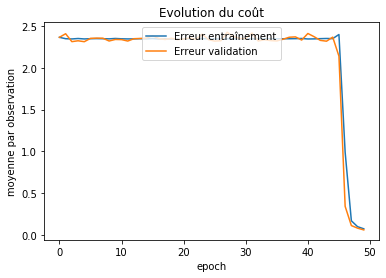

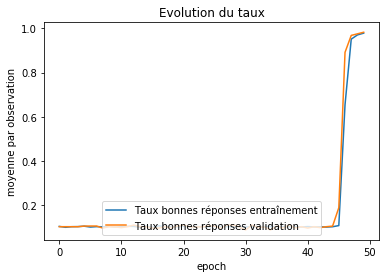

In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Exemple MNIST avec réseau LeNet (LeCun et al.)
"""
import torch
torch.manual_seed(0) # Pour résultats reproductibles

# Fonction J d'entropie croisée
import torch.nn.functional as F
fonction_cout = F.cross_entropy

def taux_bonnes_predictions(lot_Y_predictions, lot_Y):
    predictions_categorie = torch.argmax(lot_Y_predictions, dim=1)
    return (predictions_categorie == lot_Y).float().mean()

from torch import nn
# Définition de l'architecture du RNA

m = torch.nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), #(N, 1, 28, 28) -> (N, 6, 28, 28)
    nn.AvgPool2d(kernel_size=2, stride=2), #(N, 6, 28, 28) -> (N, 6, 14, 14)
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), #(N, 6, 14, 14) -> (N, 16, 10, 10)
    nn.AvgPool2d(kernel_size=2, stride=2), #(N, 16, 10, 10) -> (N, 16, 5, 5)
    nn.Flatten(), #(N, 16, 5, 5) -> (N, 400)
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(), #(N, 400) -> (N, 120)
    nn.Linear(120, 84), nn.Sigmoid(), #(N, 120) -> (N, 84)
    nn.Linear(84, 10)) #(N, 84) -> (N, 10)

from torch import optim
optimiseur = optim.SGD(m.parameters(), lr=10)

import torchvision
import torchvision.transforms as transforms

#Chargement des données
ds = torchvision.datasets.MNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
ds_ent, ds_valid = torch.utils.data.random_split(ds, [50000, 10000])
ds_test = torchvision.datasets.MNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())

#Création du DataLoader avec le dataset
dl_ent = torch.utils.data.DataLoader(ds_ent, batch_size=100, shuffle = True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=100)

def entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10):

    # Listes pour les métriques par epoch
    liste_cout_moyen_ent = []
    liste_taux_moyen_ent = []
    liste_cout_moyen_valid = []
    liste_taux_moyen_valid = []
    
    # Boucle d'apprentissage
    for epoch in range(nb_epochs):
        cout_total_ent = 0 # pour cumuler les couts par mini-lot
        taux_bonnes_predictions_ent = 0 # pour cumuler les taux par mini-lot
        modele.train() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        
        # Boucle d'apprentissage par mini-lot pour une epoch
        for lot_X, lot_Y in dl_ent:
            optimiseur.zero_grad() # Remettre les dérivées à zéro
            lot_Y_predictions = modele(lot_X) # Appel de la méthode forward
            cout = fonction_cout(lot_Y_predictions, lot_Y)
            cout.backward() # Calcul des gradiants par rétropropagation
            with torch.no_grad():
                cout_total_ent +=cout
                taux_bonnes_predictions_ent += taux_bonnes_predictions(lot_Y_predictions, lot_Y)
            optimiseur.step() # Mise à jour des paramètres
        # Calculer les moyennes par mini-lot
        with torch.no_grad():
            cout_moyen_ent = cout_total_ent/len(dl_ent)
            taux_moyen_ent = taux_bonnes_predictions_ent/len(dl_ent)
       
        modele.eval() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        with torch.no_grad():
            cout_valid = sum(fonction_cout(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
            taux_bons_valid = sum(taux_bonnes_predictions(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
        cout_moyen_valid = cout_valid/len(dl_valid)
        taux_moyen_valid = taux_bons_valid/len(dl_valid)
        print(f'-------- > epoch {epoch+1}:  coût moyen entraînement = {cout_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  taux moyen entraînement = {taux_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  coût moyen validation = {cout_moyen_valid}')
        print(f'-------- > epoch {epoch+1}:  taux moyen validation = {taux_moyen_valid}')
    
        liste_cout_moyen_ent.append(cout_moyen_ent)
        liste_taux_moyen_ent.append(taux_moyen_ent)
        liste_cout_moyen_valid.append(cout_moyen_valid)
        liste_taux_moyen_valid.append(taux_moyen_valid)
    
    # Affichage du graphique d'évolution des métriques par epoch
    import numpy as np
    import matplotlib.pyplot as plt
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_ent,label='Erreur entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_valid,label='Erreur validation')
    plt.title("Evolution du coût")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='upper center')
    plt.show()
        
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_ent,label='Taux bonnes réponses entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_valid,label='Taux bonnes réponses validation')
    plt.title("Evolution du taux")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='lower center')
    plt.show()

entrainer(m, dl_ent, dl_valid, optimiseur, nb_epochs=50)

In [4]:
X = torch.randn(size=(1, 1, 28, 28), dtype=torch.float32)
for une_couche in m:
    X = une_couche(X)
    print('Type de couche:',une_couche.__class__.__name__,'  Forme de sortie:',X.shape)

Type de couche: Conv2d   Forme de sortie: torch.Size([1, 6, 28, 28])
Type de couche: Sigmoid   Forme de sortie: torch.Size([1, 6, 28, 28])
Type de couche: AvgPool2d   Forme de sortie: torch.Size([1, 6, 14, 14])
Type de couche: Conv2d   Forme de sortie: torch.Size([1, 16, 10, 10])
Type de couche: Sigmoid   Forme de sortie: torch.Size([1, 16, 10, 10])
Type de couche: AvgPool2d   Forme de sortie: torch.Size([1, 16, 5, 5])
Type de couche: Flatten   Forme de sortie: torch.Size([1, 400])
Type de couche: Linear   Forme de sortie: torch.Size([1, 120])
Type de couche: Sigmoid   Forme de sortie: torch.Size([1, 120])
Type de couche: Linear   Forme de sortie: torch.Size([1, 84])
Type de couche: Sigmoid   Forme de sortie: torch.Size([1, 84])
Type de couche: Linear   Forme de sortie: torch.Size([1, 10])


-------- > epoch 1:  coût moyen entraînement = 0.34881943464279175
-------- > epoch 1:  taux moyen entraînement = 0.8934206366539001
-------- > epoch 1:  coût moyen validation = 0.34638237953186035
-------- > epoch 1:  taux moyen validation = 0.8947002291679382
-------- > epoch 2:  coût moyen entraînement = 0.3261716365814209
-------- > epoch 2:  taux moyen entraînement = 0.9014607667922974
-------- > epoch 2:  coût moyen validation = 0.3276556134223938
-------- > epoch 2:  taux moyen validation = 0.9022001028060913
-------- > epoch 3:  coût moyen entraînement = 0.3094905614852905
-------- > epoch 3:  taux moyen entraînement = 0.9071211218833923
-------- > epoch 3:  coût moyen validation = 0.3129377067089081
-------- > epoch 3:  taux moyen validation = 0.9073001146316528
-------- > epoch 4:  coût moyen entraînement = 0.2955019772052765
-------- > epoch 4:  taux moyen entraînement = 0.91190105676651
-------- > epoch 4:  coût moyen validation = 0.29922372102737427
-------- > epoch 4:  ta

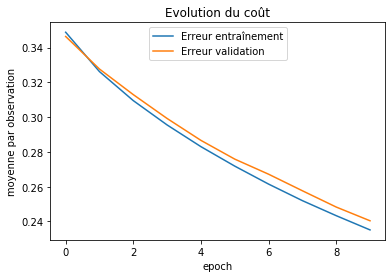

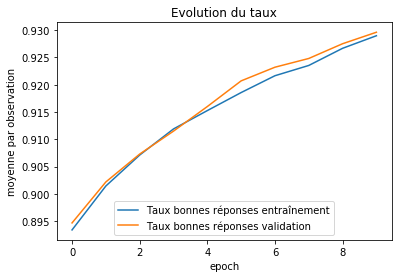

In [6]:
optimiseur = optim.SGD(m.parameters(), lr=0.05)
entrainer(m, dl_ent, dl_valid, optimiseur, nb_epochs=10)